In [ ]:
# google drive mount

from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
import pandas as pd

data = pd.read_csv('/gdrive/My Drive/KoBERT/data/data_final.csv')

In [ ]:
# 결측치 확인

print(f"null 확인:\n{data.isnull().sum()}")

null 확인:
sentence    0
emotion     0
dtype: int64


In [ ]:
# 클래스 분포 확인

data.emotion.value_counts()

화남     9612
괴로움    8096
기쁨     7572
우울함    7234
긴장됨    5526
비참함    5355
놀람     3163
중립     2115
피로함    1770
지루함     797
Name: emotion, dtype: int64

In [ ]:
# 화남, 괴로움 7500개 즈음으로 undersampling (삭제)

drop_upset_index = data[data.emotion == '화남'].sample(n=2000, random_state=0).index
drop_distressed_index = data[data.emotion == '괴로움'].sample(n=500, random_state=0).index

dataset = data.drop(drop_upset_index, axis=0)
dataset = dataset.drop(drop_distressed_index, axis=0)

In [ ]:
# 피로함, 지루함 -> 피로함으로 합치기

dataset.loc[dataset['emotion'] == '지루함', 'emotion'] = '피로함'

In [ ]:
dataset.emotion.value_counts()

화남     7612
괴로움    7596
기쁨     7572
우울함    7234
긴장됨    5526
비참함    5355
놀람     3163
피로함    2567
중립     2115
Name: emotion, dtype: int64

In [ ]:
# 한국어 아닌 데이터 제거

import re
from tqdm import tqdm

def removing_non_korean(df):
    for idx, row in tqdm(df.iterrows(), desc='removing_non_korean', total=len(df)):
        new_doc = re.sub('[^가-힣]', '', row['sentence']).strip()
        df.loc[idx, 'sentence'] = new_doc
    return df

dataset = removing_non_korean(dataset)

removing_non_korean: 100%|██████████| 48740/48740 [00:07<00:00, 6609.75it/s]


In [ ]:
# konlpy, Mecab 형태소 분석기 설치 스크립트 실행
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-10-10 16:02:28--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-10-10 16:02:29--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc283af071b1458eb191a284feab.dl.dropboxusercontent.com/cd/0/get/BuhvEsDGbax2WM0TJf3d6sS9lH5Mn7WuHzPKO9JaaBtZG9zEL1v5tYX2b5T_WN8eCtRFBem_caGbAnBTOG_5Ffo8t7HN3QJSAmj-NqKIX7qhCTsBwOob9VvAJ3szUTb7aJxbVxuCMlg2xB7e_LUAUBK5Rh4_xxXs7ZJwpqQDqvP5OCFjoXa4D_0ZOGHZGjk2HRI/file?dl=1# [following]
--2022-10-10 16:02:29--  https://uc283af071b1458eb191a284feab.dl.dropboxusercontent.com/cd/0/get/BuhvEsDGbax2

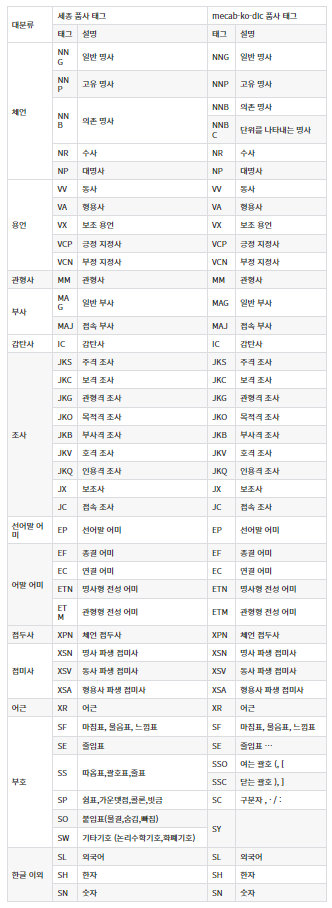

In [ ]:
# 형태소 분석 - 조사와 어미 제거

from konlpy.tag import Mecab

m = Mecab()
remove_tags = ['JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC', 'EP', 'EF', 'EC', 'ETN', 'ETM']

def remove_mecab(df, tags):
    for idx, row in tqdm(df.iterrows(), desc='removing', total=len(df)):
        removed = [x[0] for x in m.pos(row['sentence']) if x[1] not in remove_tags]
        df.loc[idx, 'sentence'] = ' '.join(removed)
    return df

dataset_mecab = remove_mecab(dataset, remove_tags)

removing: 100%|██████████| 48740/48740 [00:22<00:00, 2157.82it/s]


In [ ]:
dataset_mecab

,sentence,emotion
0,제 감정 이상 해진 것 같 남편 보 화 치밀 오르 감정 조절 안 되,화남
1,더 이상 내 감정 내 컨트롤 못 하,비참함
2,하루 종일 오르락내리락 롤러코스터 타 기분 이,비참함
3,꼭 롤러코스터 타 것 같,긴장됨
4,롤러코스터 타 것 기분 왔 갔 해요,우울함
...,...,...
51234,학교 친구 들 나 계속 따돌려 서 너무 무서워,화남
51235,부동산 임대 소득 현재 여유 롭 살 수 있 좋,기쁨
51236,폐결핵 이미 완치 된 것 같 약 한 달 더 먹 하 아직 안 나 게 아닌지 걱정 돼,피로함
51237,연애 하 싶 소개팅 나가 꽝 이 이러 난 결혼 못 하 늙 죽 거 야,비참함


In [ ]:
# 감정 라벨링

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(dataset_mecab['emotion'])
dataset_mecab['emotion'] = encoder.transform(dataset_mecab['emotion'])
dataset_mecab

,sentence,emotion
0,제 감정 이상 해진 것 같 남편 보 화 치밀 오르 감정 조절 안 되,8
1,더 이상 내 감정 내 컨트롤 못 하,4
2,하루 종일 오르락내리락 롤러코스터 타 기분 이,4
3,꼭 롤러코스터 타 것 같,2
4,롤러코스터 타 것 기분 왔 갔 해요,5
...,...,...
51234,학교 친구 들 나 계속 따돌려 서 너무 무서워,8
51235,부동산 임대 소득 현재 여유 롭 살 수 있 좋,1
51236,폐결핵 이미 완치 된 것 같 약 한 달 더 먹 하 아직 안 나 게 아닌지 걱정 돼,7
51237,연애 하 싶 소개팅 나가 꽝 이 이러 난 결혼 못 하 늙 죽 거 야,4


In [ ]:
mapping = dict(zip(range(len(encoder.classes_)), encoder.classes_))
mapping

{0: '괴로움',
 1: '기쁨',
 2: '긴장됨',
 3: '놀람',
 4: '비참함',
 5: '우울함',
 6: '중립',
 7: '피로함',
 8: '화남'}

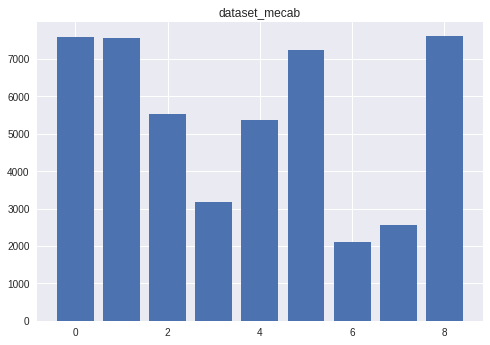

In [ ]:
# 클래스 분포 확인

import matplotlib.pyplot as plt

plt.style.use('seaborn')

dataset_mecab_vlcnt = dataset_mecab['emotion'].value_counts().reset_index()

plt.title('dataset_mecab')
plt.bar(dataset_mecab_vlcnt['index'], dataset_mecab_vlcnt['emotion'])

plt.show()

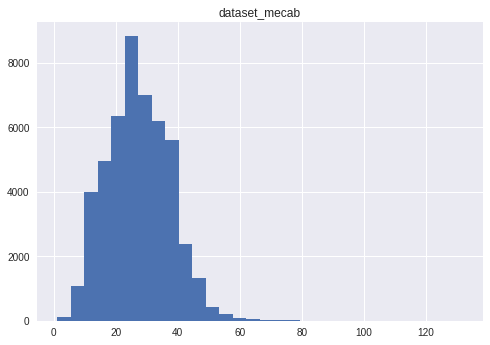

In [ ]:
# sentence 길이 분포 확인

import numpy as np

plt.style.use('seaborn')

dataset_mecab_len = [len(x) for x in dataset_mecab['sentence']]

plt.title('dataset_mecab')
plt.hist(dataset_mecab_len, bins=30)

plt.show()

In [ ]:
# 전처리 완료

dataset_mecab.to_csv('/gdrive/My Drive/KoBERT/data/data_mecab.csv', index=False)